In [1]:
import json
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.weight'] = 'bold'

In [3]:
protein_mapping = {
    "x1": "Clock/Bmal_N",
    "x2": "Per/Cry_N^tot",
    "x5": "Rev-Erb_N",
    "x6": "Ror_N",
    "y1": "Per",
    "y2": "Cry",
    "y3": "Rev-Erb",
    "y4": "Ror",
    "y5": "Bmal",
    "y6": "Clock",
    "z1": "Cry_C",
    "z2": "Per_C^tot",
    "z4": "Per/Cry_C^tot",
    "z5": "Clock_C",
    "z6": "Rev-Erb_C",
    "z7": "Ror_C",
    "z8": "Bmal_C",
    "z9": "Clock/Bmal_C"
}
params_list = [
    # degradation rates
    'dr_x1', 'dr_x2', 'dr_x5', 'dr_x6',
    'dr_y1', 'dr_y2', 'dr_y3', 'dr_y4', 'dr_y5', 'dr_y6',
    'dr_z1', 'dr_z2', 'dr_z5', 'dr_z6', 'dr_z7', 'dr_z8',
    # reaction rates for complex formation/dissociation
    'kf_z9', 'kf_z4', 'kd_z9', 'kd_z4',
    # transcription rates
    'tr_y1', 'tr_y2', 'tr_y3', 'tr_y4', 'tr_y5', 'tr_y6',
    # activation/inhibition rates
    'ar_y1', 'ar_y2', 'ar_y3', 'ar_y4', 'ar_y5', 'ar_y6',
    'ir_y1', 'ir_y2', 'ir_y21', 'ir_y3', 'ir_y4', 'ir_y5', 'ir_y6',
    # transcription fold activation
    'a', 'd', 'g', 'h', 'i', 'j',
    # production rates
    'pr_z1', 'pr_z2', 'pr_z5', 'pr_z6', 'pr_z7', 'pr_z8',
    # import/export rates
    'impr_z4', 'impr_z6', 'impr_z7', 'impr_z9',
    'expr_x1', 'expr_x2',
    # hill coefficients
    'b', 'c', 'e', 'f', 'f1',
    # volume proportions
    'vc', 'vn'
]

In [4]:
def initialize_params(literature = False):
    '''
    Args >>>
    - literature: boolean
    
    To use the parameters from the literature, set the boolean to True.
    These parameters from the literature are to test and validate our results.
    '''
    if literature:
        return pd.concat([
            pd.read_json('degradation_rates.json', typ = 'series'),
            pd.read_json('reaction_rates.json', typ = 'series'),
            pd.read_json('transcription_rates.json', typ = 'series'),
            pd.read_json('activation_inhibition_rates.json', typ = 'series'),
            pd.read_json('transcription_fold_activation_rates.json', typ = 'series'),
            pd.read_json('production_rates.json', typ = 'series'),
            pd.read_json('import_export_rates.json', typ = 'series'),
            pd.read_json('hill_coefficients_of_transcription.json', typ = 'series'),
            pd.read_json('volume_proportions.json', typ = 'series')
        ])
    else:
        tmp = np.random.rand()
        values = np.concatenate((
            np.random.rand(16), # degradation rates
            np.random.rand(2), # reaction rates for complex formation
            np.random.rand(2), # reaction rates for complex dissociation
            np.random.rand(6), # transcription rates
            np.random.rand(13), # activation/inhibition rates
            np.random.rand(6) * 10, # transcription fold activation
            np.random.rand(6) * 1e3, # production rates
            np.random.rand(6), # import/export rates
            np.random.rand(5), # hill coefficients
            np.array([tmp, 1-tmp]) # volume proportions
        ))
        return pd.Series(values, params_list)

In [5]:
def circadian_clock(t, proteins, params):
    '''
    function to compute the odes in the circadian clock model
    - these odes are based on the model proposed by Relogio et al. (2011) [1]
      and later modified by Hesse et al. (2021) [2]
    this is just the core clock which does not capture any interactions with external factors like drugs or stimuli (like light)
    TODO: these external factors would be incorporated in a separate function which computes the coupled odes for the factors
    TODO: update the function to take separate input for genes and proteins

    References:
    [1] A. Rel´ogio, P. O. Westermark, T. Wallach, K. Schellenberg, A. Kramer, and H. Herzel, Tuning the mammalian circadian clock: robust synergy of two loops, PLoS computational biology, 7 (2011), p. e1002309.
    [2] J. Hesse, J. Martinelli, O. Aboumanify, A. Ballesta, and A. Rel´ogio, A mathematical model of the circadian clock and drug pharmacology to optimize irinotecan administration timing in colorectal cancer, Computational and Structural Biotechnology Journal, 19 (2021), pp. 5170–5183.
    '''
    # unpacking the values of the proteins
    x1, x2, x5, x6 = proteins[:4]
    y1, y2, y3, y4, y5 = proteins[4:9]
    z1, z2, z4, z5, z6, z7, z8, z9 = proteins[9:17]
    y6 = proteins[17]
    ratio = params['vc'] / params['vn']

    # odes for nuclear proteins and protein complexes
    dx1dt = params['impr_z9'] * z9 - params['expr_x1'] * x1 - params['dr_x1'] * x1
    dx2dt = params['impr_z4'] * z4 - params['expr_x2'] * x2 - params['dr_x2'] * x2
    dx5dt = params['impr_z6'] * z6 - params['dr_x5'] * x5
    dx6dt = params['impr_z7'] * z7 - params['dr_x6'] * x6

    # odes for core genes for the circadian clock
    dy1dthelper = (x1 / params['ar_y1'] / 1e-9)**params['b']
    dy1dt = params['tr_y1'] * 1e-9 * (1 + params['a'] * dy1dthelper) / (1 + dy1dthelper * (1 + (x2 / params['ir_y1'] / 1e-9)**params['c'])) - params['dr_y1'] * y1
    dy2dthelper = (x1 / params['ar_y2'] / 1e-9)**params['e']
    dy2dt = params['tr_y2'] * 1e-9 * (1 + params['d'] * dy2dthelper) / (1 + dy2dthelper * (1 + (x2 / params['ir_y2'] / 1e-9)**params['f'])) * (1 / (1 + (x5 / params['ir_y21'] / 1e-9)**params['f1'])) - params['dr_y2'] * y2
    dy3dthelper = (x1 / params['ar_y3'] / 1e-9)**params['b']
    dy3dt = params['tr_y3'] * 1e-9 * (1 + params['g'] * dy3dthelper) / (1 + dy3dthelper * (1 + (x2 / params['ir_y3'] / 1e-9)**params['c'])) - params['dr_y3'] * y3
    dy4dthelper = (x1 / params['ar_y4'] / 1e-9)**params['b']
    dy4dt = params['tr_y4'] * 1e-9 * (1 + params['h'] * dy4dthelper) / (1 + dy4dthelper * (1 + (x2 / params['ir_y4'] / 1e-9)**params['c'])) - params['dr_y4'] * y4
    dy5dthelper = (x6 / params['ar_y5'] / 1e-9)**params['b']
    dy5dt = params['tr_y5'] * 1e-9 * (1 + params['i'] * dy5dthelper) / (1 + dy5dthelper + (x5 / params['ir_y5'] / 1e-9)**params['c']) - params['dr_y5'] * y5
    dy6dthelper = (x6 / params['ar_y6'] / 1e-9)**params['b']
    dy6dt = params['tr_y6'] * 1e-9 * (1 + params['j'] * dy6dthelper) / (1 + dy6dthelper + (x5 / params['ir_y6'] / 1e-9)**params['c']) - params['dr_y6'] * y6

    # odes for cytoplasmic proteins and protein complexes
    dz1dt = params['pr_z1'] * y2 + params['kd_z4'] * z4 - params['kf_z4'] * 1e9 * z1 * z2 - params['dr_z1'] * z1
    dz2dt = params['pr_z2'] * y1 + params['kd_z4'] * z4 - params['kf_z4'] * 1e9 * z1 * z2 - params['dr_z2'] * z2
    dz4dt = params['kf_z4'] * 1e9 * z1 * z2 + ratio * params['expr_x2'] * x2 - ratio * params['impr_z4'] * z4 - params['kd_z4'] * z4
    dz5dt = params['pr_z5'] * y6 + params['kd_z9'] * z9 - params['kf_z9'] * 1e9 * z8 * z5 - params['dr_z5'] * z5
    dz6dt = params['pr_z6'] * y3 - ratio * params['impr_z6'] * z6 - params['dr_z6'] * z6
    dz7dt = params['pr_z7'] * y4 - ratio * params['impr_z7'] * z7 - params['dr_z7'] * z7
    dz8dt = params['pr_z8'] * y5 + params['kd_z9'] * z9 - params['kf_z9'] * 1e9 * z5 * z8 - params['dr_z8'] * z8
    dz9dt = params['kf_z9'] * 1e9 * z8 * z5 + ratio * params['expr_x1'] * x1 - ratio * params['impr_z9'] * z9 - params['kd_z9'] * z9
    
    odes = [dx1dt, dx2dt, dx5dt, dx6dt, dy1dt, dy2dt, dy3dt, dy4dt, dy5dt, dz1dt, dz2dt, dz4dt, dz5dt, dz6dt, dz7dt, dz8dt, dz9dt, dy6dt]
    return odes

In [6]:
class CircadianModel:
    '''
    CircadianModel is a class to aid the creation of the model, simplify solving the odes and act as a utility for model training and parameter optimization.
    '''
    def __init__(self, init, t_start, t_end, dt, params):
        # initial value of the variables -> genes and proteins
        self.init = init
        # time based variables -> start time of the simulation, end time and time step
        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt
        self.t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)
        # parameters for the system of odes
        self.params = params
        # to track the past values of the parameters -> used to optimize the values
        self.prev_params = params
        # to track the past values of the loss/objective function
        self.prev_loss = np.inf
        
    def solver(self, params = None, method = 'Radau', atol = 1e-9, rtol = 1e-9):
        '''
        Args >>>
        - params: values for the parameters
        - method, atol, rtol: for the solver
        
        TODO: init values could also be an input
        '''
        if params is not None:
            parameters = params
        else:
            parameters = self.params
        return solve_ivp(
            fun = lambda t, p: circadian_clock(t, p, parameters.to_dict()),
            t_span = [self.t_start, self.t_end],
            y0 = list(self.init.values()),
            t_eval = self.t_eval,
            method = method,
            atol = atol,
            rtol = rtol
        )
    
    def processing_solution(self, solution, params = None, interval = 48, jumps = 4):
        '''
        Args >>>
        - solution: from the solver
        - params: value of parameters for the odes
        - interval: duration of the ode to process
        - jumps: resolution of the duration
        
        We have experimental data on protein properties which are a linear combination of the protein variables in the odes.
        To compare the solution of the odes with experimental data, we need to process the solution to arrive at the desired format
        
        FAR-FETCHED TODO: further simply the model to only use these experimental entities >> to be done based on time availability
        '''
        if params is not None:
            parameters = params
        else:
            parameters = self.params
        slice_start = int((self.t_end - interval) / self.dt)
        slice_end = int(self.t_end / self.dt)
        slice_step = int(jumps / self.dt)
        out = solution.y[:, slice_start:slice_end:slice_step]
        gene = out[[4, 5, 6, 7, 8, -1]]
        protein = np.zeros(gene.shape)
        # vc and vn are fractions to denote the volume of cytoplasm and nucleus respectively, and they "should" add to 1
        total = parameters['vc'] + parameters['vn']
        # the total concentration of the proteins are easier to measure compared to their cytoplasmic and nucleic concentrations
        # these total concentrations are expressed in terms of the cytoplasmic and nucleic species of these proteins and their complexes
        protein[0] = parameters['vc'] * (out[15] + out[16]) + parameters['vn'] * out[0]
        protein[1] = parameters['vc'] * (out[12] + out[16]) + parameters['vn'] * out[0]
        protein[2] = parameters['vc'] * (out[10] + out[11]) + parameters['vn'] * out[1]
        protein[3] = parameters['vc'] * (out[9] + out[11]) + parameters['vn'] * out[1]
        protein[4] = parameters['vc'] * out[13] + parameters['vn'] * out[2]
        protein[5] = parameters['vc'] * out[14] + parameters['vn'] * out[3]
        return gene, protein/total
    
    def objective_function(self, params, gene_targets, protein_targets, method = 'Radau', atol = 1e-9, rtol = 1e-9):
        '''
        Args >>>
        - gene_targets, protein_targets: data from experiments
        
        We define the objective function to optimize the parameters for the odes
        The objective function has the form of least squares, but the gene variables have been scaled to have similar importance in the objective function
        The gene variables are in picomol/L and protein variables are in nanomol/L
        
        TODO: while optimizing, the solver gets stuck in a pit so we are exploring ways to resolve this behavior and arrive at better parameters
        Currently, we are taking the largest moved parameter and shaking up the value to reach a different pit but this needs further work
        '''
        # solver attempts to solve the equation
        # if the solver fails to converge at a solution then we pick the largest changed parameter and update the value to hope for a different solution
        # the update is by a factor upto 1
        # NOTE. the print statements are a bit weird, and kept the way due to ongoing debugging? ignore them for now if it makes no sense.
        try:
            solution = self.solver(pd.Series(params, params_list), method, atol, rtol)
        except:
            update_index = int(np.argmax(np.abs(params - self.prev_params)))
            print('\twhat happened here?', update_index)
            new_params = initialize_params().to_numpy()
            print('\tOriginal: {}, Pot. Opt.: {}, Reinit.: {}'.format(self.prev_params.to_numpy()[update_index], params[update_index], new_params[update_index], self.prev_params.to_numpy()[update_index] * new_params[update_index]))
#             self.prev_params = pd.Series(np.copy(params), params_list)
            params[update_index] = self.prev_params.to_numpy()[update_index] * new_params[update_index]
            self.params = pd.Series(params, params_list)
            print('\tLoss achieved: ', self.prev_loss, np.abs(self.prev_params - self.params).max())
            self.prev_loss = np.inf
            raise ValueError('updated params...')
        gene_preds, protein_preds = self.processing_solution(solution)
        protein_preds = protein_preds[:, :6]
        # trying this thing? >>> experiment of many others
        # this experiment is to address any issue with the result from the solver
        # at times, the solver does not provide the entire solution due to instability from randomised parameters
        # this following line fills in the empty cells with repetition from the previously filled cells as a way to tackle this problem
        gene_preds = np.resize(gene_preds, gene_targets.shape); protein_preds = np.resize(protein_preds, protein_targets.shape)
        norm_gene = np.max(gene_targets, axis = 1).reshape(-1, 1)
        norm_protein = np.max(protein_targets, axis = 1).reshape(-1, 1)
        diff_gene = gene_targets - gene_preds
        diff_protein = protein_targets - protein_preds
        self.prev_loss = np.sqrt(np.mean((diff_gene)**2) * 1e6 + np.mean((diff_protein)**2))
        self.prev_params = pd.Series(np.copy(params), params_list)
        return np.sqrt(np.mean((diff_gene)**2) * 1e6 + np.mean((diff_protein)**2))


In [7]:
# vc + vn = 1; cytoplasmic and nucleic volumes sum to 1, they form the living cell
def volume_constraint(params):
    return params[-2] + params[-1] - 1

# now redundant, TO BE DELETED
def positive_constraint(params):
    return params

In [8]:
# testing the workflow and functions with parameters from the literature
with open('initial_values.json') as f:
    init = json.load(f)
t_start = 0
t_end = 600
dt = 0.1
# t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)
parameters = initialize_params(True)
clock = CircadianModel(init, t_start, t_end, dt, parameters)

In [9]:
soln = clock.solver()

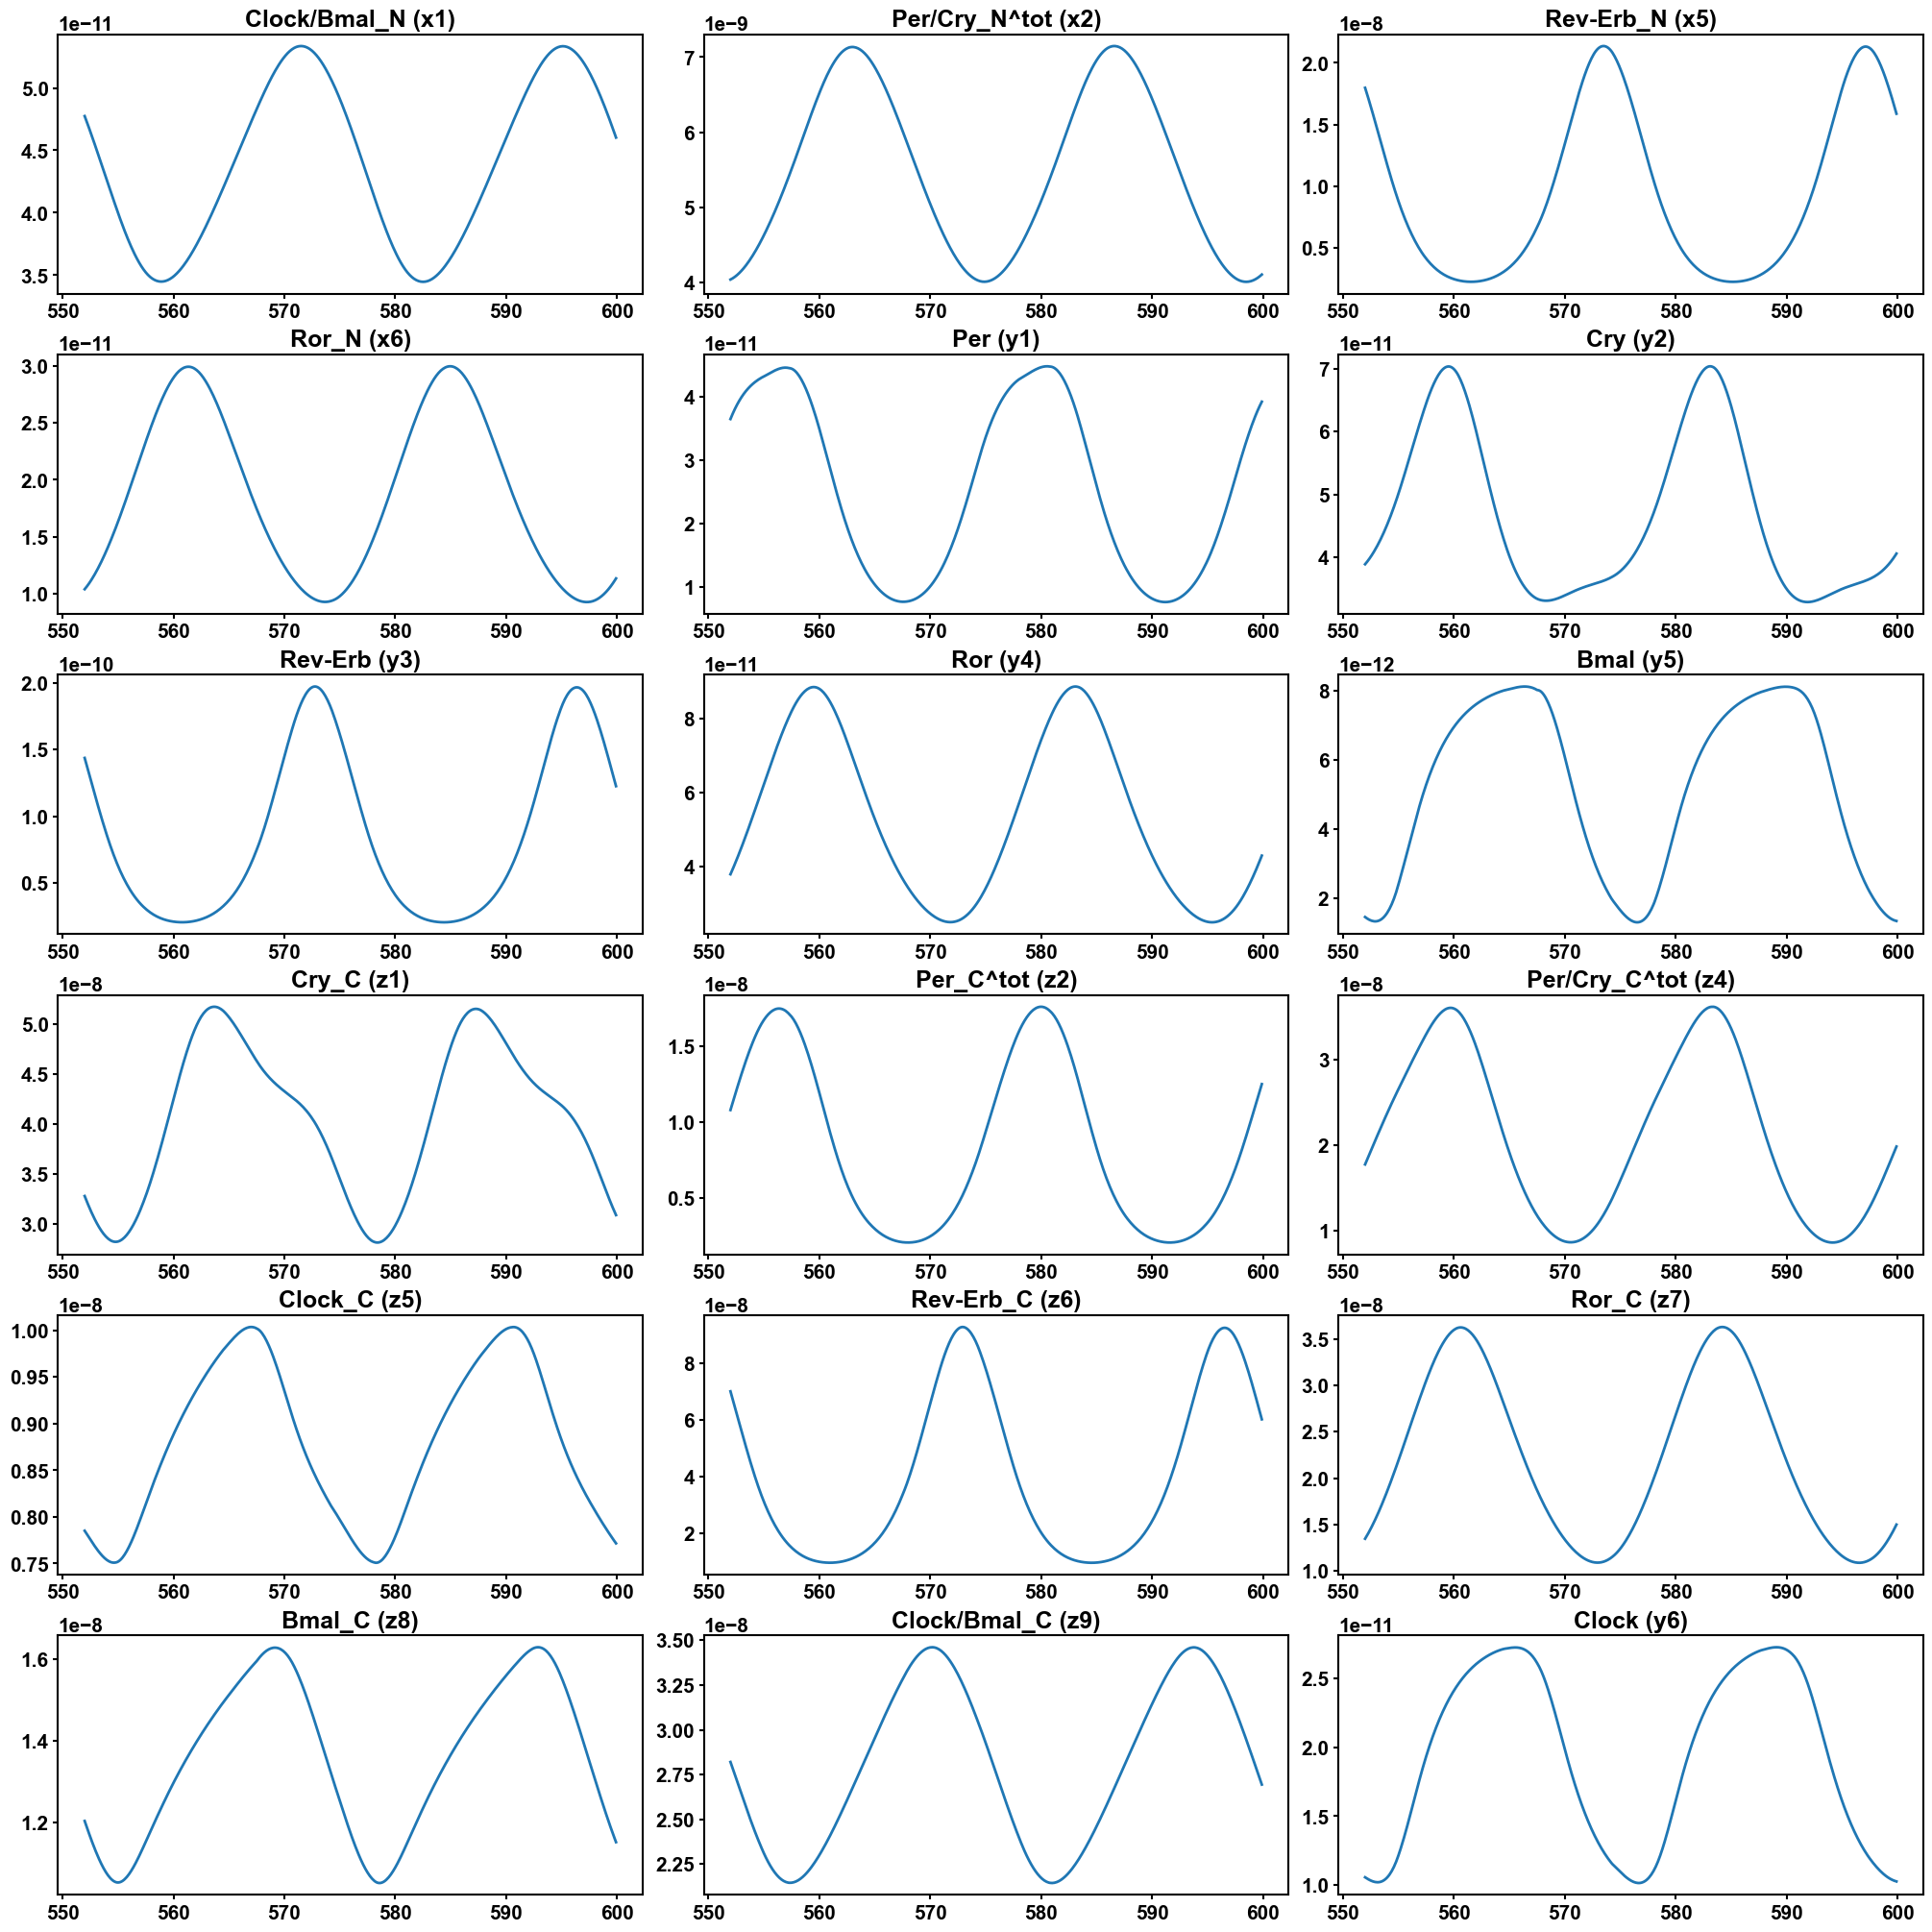

In [10]:
plt_start = int((t_end - 48) / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (20,20), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln.t[plt_start:plt_end]
    prot = soln.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(protein_mapping[var], var), fontsize = 18, weight = 'bold')
# _ = fig.supylabel('Concentration (nmol/L)', fontsize = 22, weight = 'bold')
# _ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
# plt.savefig('circadian_clock_portion.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

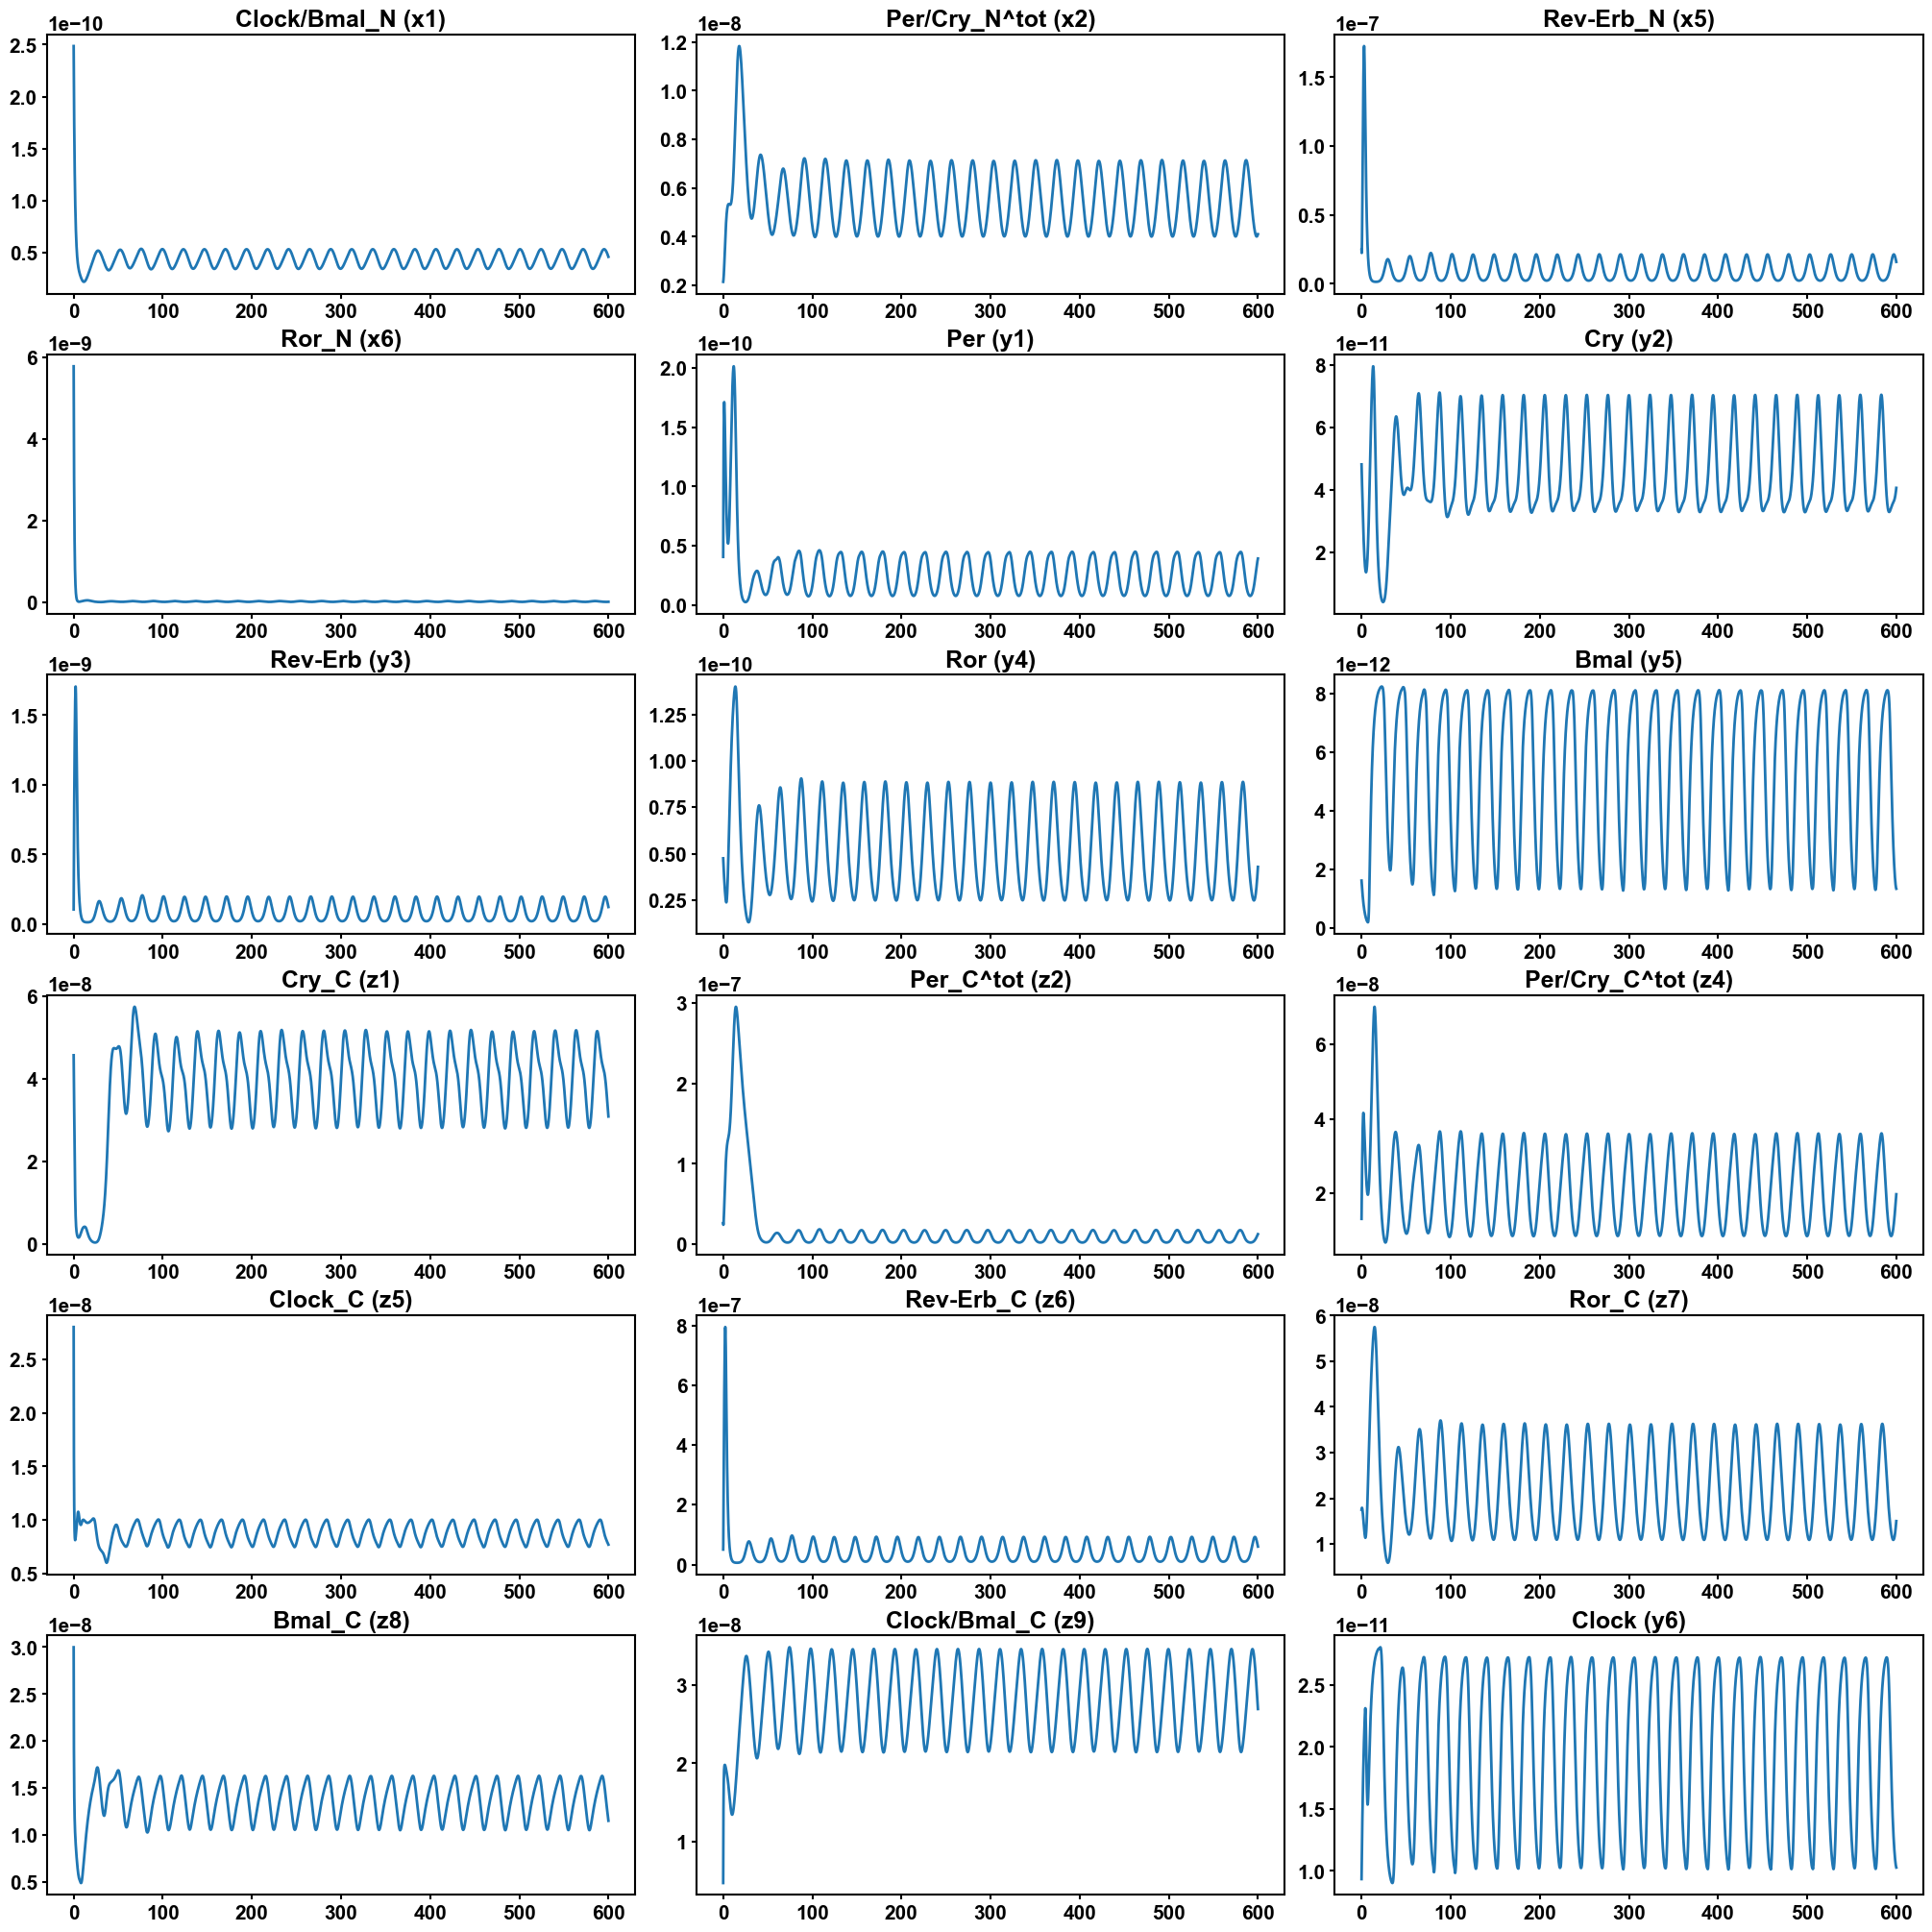

In [11]:
plt_start = int(t_start / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (20,20), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln.t[plt_start:plt_end]
    prot = soln.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(protein_mapping[var], var), fontsize = 18, weight = 'bold')
# _ = fig.supylabel('Concentration (nmol/L)', fontsize = 22, weight = 'bold')
# _ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
# plt.savefig('circadian_clock_entire_period.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

In [12]:
# loading the processed data for gene and protein
# TODO: add the data processing routine
gene_data = pd.read_csv('processed_gene.csv')
protein_data = pd.read_csv('processed_protein.csv')

In [13]:
gene_data['id'] = ['y5', 'y6', 'y2', 'y1', 'y3', 'y4']
gene_targets = gene_data.sort_values('id').filter(regex='ct').to_numpy()

In [14]:
protein_targets = protein_data.filter(regex='ct').to_numpy()

In [ ]:
# attempt at optimizing the parameters, we are training multiple models and eventually taking an ensemble average?
# either way, we can check multiple models and still pick the best one if not ensemble average
list_opt = []
for i in range(10):
    clock1 = CircadianModel(init, t_start, t_end, dt, initialize_params(False))
    print('-----> MODEL ', i)
    opt_params = None
    count = 0
    while count < 25 and opt_params is None:
        try:
            print('Attempt {} at minimization...'.format(count))
            opt_params = minimize(clock1.objective_function, clock1.params,
                                  args = (gene_targets, protein_targets),
                                  options = {'ftol': 1e-18, 'maxiter': 200},
                                  constraints = [{'type': 'eq', 'fun': volume_constraint}],
                                  bounds = [(0, None) for i in range(clock.params.shape[0] - 2)] + [(0, 1), (0, 1)]
                                 )
        except Exception as e:
            count += 1
            print(e)
            pass
    list_opt.append(opt_params)

-----> MODEL  0
Attempt 0 at minimization...
	what happened here? 16
	Original: 0.9543941524702657, Pot. Opt.: 0.9543941375691045, Reinit.: 0.9052683395095724
	Loss achieved:  1.8807949247197797e-07 0.0904113428258626
updated params...
Attempt 1 at minimization...


In [ ]:
# checking the predicted parameters
np.abs(opt_params.x - parameters).sort_values(ascending=False)

In [ ]:
# just some analysis
np.abs(opt_params.x - parameters)[np.abs(opt_params.x - parameters) > 1e-2]

In [ ]:
# taking ensemble average
final_params = np.zeros(opt_params.x.shape)
valid_opt = 0
for opt in list_opt:
    if opt is not None:
        final_params += opt.x
        valid_opt += 1
final_params = final_params/valid_opt
np.abs(final_params - parameters).sort_values(ascending = False)

In [ ]:
# observing the the solution for the odes with the optimized parameters
# however, the parameters need to be fully optimized and the following results are not great
clock2 = CircadianModel(init, t_start, t_end, dt, pd.Series(final_params, params_list))

In [ ]:
soln2 = clock2.solver()

In [ ]:
plt_start = int(t_start / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (20,20), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln2.t[plt_start:plt_end]
    prot = soln2.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(protein_mapping[var], var), fontsize = 18, weight = 'bold')
# _ = fig.supylabel('Concentration (nmol/L)', fontsize = 22, weight = 'bold')
# _ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
# plt.savefig('circadian_clock_portion.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

In [15]:
from scipy.optimize import fsolve
from scipy.linalg import eig

In [16]:
##the steady state analysis for the existing model

In [17]:
def steady_state_analysis(params):
    def equations(variables):
        x1, x2, x5, x6, y1, y2, y3, y4, y5, y6, z1, z2, z4, z5, z6, z7, z8, z9 = variables
        ratio = params['vc'] / params['vn']
        
        eq1 = params['impr_z9'] * z9 - params['expr_x1'] * x1 - params['dr_x1'] * x1
        eq2 = params['impr_z4'] * z4 - params['expr_x2'] * x2 - params['dr_x2'] * x2
        eq3 = params['impr_z6'] * z6 - params['dr_x5'] * x5
        eq4 = params['impr_z7'] * z7 - params['dr_x6'] * x6
        
        dy1dthelper = (x1 / params['ar_y1'] / 1e-9)**params['b']
        eq5 = params['tr_y1'] * 1e-9 * (1 + params['a'] * dy1dthelper) / (1 + dy1dthelper * (1 + (x2 / params['ir_y1'] / 1e-9)**params['c'])) - params['dr_y1'] * y1
        dy2dthelper = (x1 / params['ar_y2'] / 1e-9)**params['e']
        eq6 = params['tr_y2'] * 1e-9 * (1 + params['d'] * dy2dthelper) / (1 + dy2dthelper * (1 + (x2 / params['ir_y2'] / 1e-9)**params['f'])) * (1 / (1 + (x5 / params['ir_y21'] / 1e-9)**params['f1'])) - params['dr_y2'] * y2
        dy3dthelper = (x1 / params['ar_y3'] / 1e-9)**params['b']
        eq7 = params['tr_y3'] * 1e-9 * (1 + params['g'] * dy3dthelper) / (1 + dy3dthelper * (1 + (x2 / params['ir_y3'] / 1e-9)**params['c'])) - params['dr_y3'] * y3
        dy4dthelper = (x1 / params['ar_y4'] / 1e-9)**params['b']
        eq8 = params['tr_y4'] * 1e-9 * (1 + params['h'] * dy4dthelper) / (1 + dy4dthelper * (1 + (x2 / params['ir_y4'] / 1e-9)**params['c'])) - params['dr_y4'] * y4
        dy5dthelper = (x6 / params['ar_y5'] / 1e-9)**params['b']
        eq9 = params['tr_y5'] * 1e-9 * (1 + params['i'] * dy5dthelper) / (1 + dy5dthelper + (x5 / params['ir_y5'] / 1e-9)**params['c']) - params['dr_y5'] * y5
        dy6dthelper = (x6 / params['ar_y6'] / 1e-9)**params['b']
        eq10 = params['tr_y6'] * 1e-9 * (1 + params['j'] * dy6dthelper) / (1 + dy6dthelper + (x5 / params['ir_y6'] / 1e-9)**params['c']) - params['dr_y6'] * y6
        
        eq11 = params['pr_z1'] * y2 + params['kd_z4'] * z4 - params['kf_z4'] * 1e9 * z1 * z2 - params['dr_z1'] * z1
        eq12 = params['pr_z2'] * y1 + params['kd_z4'] * z4 - params['kf_z4'] * 1e9 * z1 * z2 - params['dr_z2'] * z2
        eq13 = params['kf_z4'] * 1e9 * z1 * z2 + ratio * params['expr_x2'] * x2 - ratio * params['impr_z4'] * z4 - params['kd_z4'] * z4
        eq14 = params['pr_z5'] * y6 + params['kd_z9'] * z9 - params['kf_z9'] * 1e9 * z8 * z5 - params['dr_z5'] * z5
        eq15 = params['pr_z6'] * y3 - ratio * params['impr_z6'] * z6 - params['dr_z6'] * z6
        eq16 = params['pr_z7'] * y4 - ratio * params['impr_z7'] * z7 - params['dr_z7'] * z7
        eq17 = params['pr_z8'] * y5 + params['kd_z9'] * z9 - params['kf_z9'] * 1e9 * z5 * z8 - params['dr_z8'] * z8
        eq18 = params['kf_z9'] * 1e9 * z8 * z5 + ratio * params['expr_x1'] * x1 - ratio * params['impr_z9'] * z9 - params['kd_z9'] * z9
        
        return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9, eq10, eq11, eq12, eq13, eq14, eq15, eq16, eq17, eq18]
    
    initial_guess = np.ones(18)
    solution = fsolve(equations, initial_guess)
    return solution

In [18]:
##the stability analysis 

In [19]:
def stability_analysis(params, steady_state):
    def jacobian(variables):
        x1, x2, x5, x6, y1, y2, y3, y4, y5, y6, z1, z2, z4, z5, z6, z7, z8, z9 = variables
        ratio = params['vc'] / params['vn']
        J = np.zeros((18, 18))

        # Partial derivatives for x1, x2, x5, x6
        J[0, 0] = -params['expr_x1'] - params['dr_x1']
        J[0, 17] = params['impr_z9']
        J[1, 1] = -params['expr_x2'] - params['dr_x2']
        J[1, 12] = params['impr_z4']
        J[2, 2] = -params['dr_x5']
        J[2, 14] = params['impr_z6']
        J[3, 3] = -params['dr_x6']
        J[3, 15] = params['impr_z7']

        # Partial derivatives for y1, y2, y3, y4, y5, y6
        dy1dthelper = (x1 / params['ar_y1'] / 1e-9)**params['b']
        dy2dthelper = (x1 / params['ar_y2'] / 1e-9)**params['e']
        dy3dthelper = (x1 / params['ar_y3'] / 1e-9)**params['b']
        dy4dthelper = (x1 / params['ar_y4'] / 1e-9)**params['b']
        dy5dthelper = (x6 / params['ar_y5'] / 1e-9)**params['b']
        dy6dthelper = (x6 / params['ar_y6'] / 1e-9)**params['b']

        J[4, 0] = params['tr_y1'] * 1e-9 * params['a'] * params['b'] * dy1dthelper / (x1 * (1 + dy1dthelper * (1 + (x2 / params['ir_y1'] / 1e-9)**params['c'])))
        J[4, 1] = -params['tr_y1'] * 1e-9 * (1 + params['a'] * dy1dthelper) * dy1dthelper * params['c'] * (x2 / params['ir_y1'] / 1e-9)**(params['c']-1) / (params['ir_y1'] * 1e-9 * (1 + dy1dthelper * (1 + (x2 / params['ir_y1'] / 1e-9)**params['c']))**2)
        J[4, 4] = -params['dr_y1']

        J[5, 0] = params['tr_y2'] * 1e-9 * params['d'] * params['e'] * dy2dthelper / (x1 * (1 + dy2dthelper * (1 + (x2 / params['ir_y2'] / 1e-9)**params['f'])))
        J[5, 1] = -params['tr_y2'] * 1e-9 * (1 + params['d'] * dy2dthelper) * dy2dthelper * params['f'] * (x2 / params['ir_y2'] / 1e-9)**(params['f']-1) / (params['ir_y2'] * 1e-9 * (1 + dy2dthelper * (1 + (x2 / params['ir_y2'] / 1e-9)**params['f']))**2)
        J[5, 2] = -params['tr_y2'] * 1e-9 * (1 + params['d'] * dy2dthelper) / (1 + dy2dthelper * (1 + (x2 / params['ir_y2'] / 1e-9)**params['f'])) * params['f1'] * (x5 / params['ir_y21'] / 1e-9)**(params['f1']-1) / (params['ir_y21'] * 1e-9 * (1 + (x5 / params['ir_y21'] / 1e-9)**params['f1'])**2)
        J[5, 5] = -params['dr_y2']

        J[6, 0] = params['tr_y3'] * 1e-9 * params['g'] * params['b'] * dy3dthelper / (x1 * (1 + dy3dthelper * (1 + (x2 / params['ir_y3'] / 1e-9)**params['c'])))
        J[6, 1] = -params['tr_y3'] * 1e-9 * (1 + params['g'] * dy3dthelper) * dy3dthelper * params['c'] * (x2 / params['ir_y3'] / 1e-9)**(params['c']-1) / (params['ir_y3'] * 1e-9 * (1 + dy3dthelper * (1 + (x2 / params['ir_y3'] / 1e-9)**params['c']))**2)
        J[6, 6] = -params['dr_y3']

        J[7, 0] = params['tr_y4'] * 1e-9 * params['h'] * params['b'] * dy4dthelper / (x1 * (1 + dy4dthelper * (1 + (x2 / params['ir_y4'] / 1e-9)**params['c'])))
        J[7, 1] = -params['tr_y4'] * 1e-9 * (1 + params['h'] * dy4dthelper) * dy4dthelper * params['c'] * (x2 / params['ir_y4'] / 1e-9)**(params['c']-1) / (params['ir_y4'] * 1e-9 * (1 + dy4dthelper * (1 + (x2 / params['ir_y4'] / 1e-9)**params['c']))**2)
        J[7, 7] = -params['dr_y4']

        J[8, 2] = -params['tr_y5'] * 1e-9 * (1 + params['i'] * dy5dthelper) * params['c'] * (x5 / params['ir_y5'] / 1e-9)**(params['c']-1) / (params['ir_y5'] * 1e-9 * (1 + dy5dthelper + (x5 / params['ir_y5'] / 1e-9)**params['c'])**2)
        J[8, 3] = params['tr_y5'] * 1e-9 * params['i'] * params['b'] * dy5dthelper / (x6 * (1 + dy5dthelper + (x5 / params['ir_y5'] / 1e-9)**params['c']))
        J[8, 8] = -params['dr_y5']

        J[9, 2] = -params['tr_y6'] * 1e-9 * (1 + params['j'] * dy6dthelper) * params['c'] * (x5 / params['ir_y6'] / 1e-9)**(params['c']-1) / (params['ir_y6'] * 1e-9 * (1 + dy6dthelper + (x5 / params['ir_y6'] / 1e-9)**params['c'])**2)
        J[9, 3] = params['tr_y6'] * 1e-9 * params['j'] * params['b'] * dy6dthelper / (x6 * (1 + dy6dthelper + (x5 / params['ir_y6'] / 1e-9)**params['c']))
        J[9, 9] = -params['dr_y6']

        # Partial derivatives for z1, z2, z4, z5, z6, z7, z8, z9
        J[10, 5] = params['pr_z1']
        J[10, 10] = -params['kf_z4'] * 1e9 * z2 - params['dr_z1']
        J[10, 11] = -params['kf_z4'] * 1e9 * z1
        J[10, 12] = params['kd_z4']

        J[11, 4] = params['pr_z2']
        J[11, 10] = -params['kf_z4'] * 1e9 * z2
        J[11, 11] = -params['kf_z4'] * 1e9 * z1 - params['dr_z2']
        J[11, 12] = params['kd_z4']

        J[12, 1] = ratio * params['expr_x2']
        J[12, 10] = params['kf_z4'] * 1e9 * z2
        J[12, 11] = params['kf_z4'] * 1e9 * z1
        J[12, 12] = -ratio * params['impr_z4'] - params['kd_z4']

        J[13, 9] = params['pr_z5']
        J[13, 13] = -params['kf_z9'] * 1e9 * z8 - params['dr_z5']
        J[13, 16] = -params['kf_z9'] * 1e9 * z5
        J[13, 17] = params['kd_z9']

        J[14, 6] = params['pr_z6']
        J[14, 14] = -ratio * params['impr_z6'] - params['dr_z6']

        J[15, 7] = params['pr_z7']
        J[15, 15] = -ratio * params['impr_z7'] - params['dr_z7']

        J[16, 8] = params['pr_z8']
        J[16, 13] = -params['kf_z9'] * 1e9 * z8
        J[16, 16] = -params['kf_z9'] * 1e9 * z5 - params['dr_z8']
        J[16, 17] = params['kd_z9']

        J[17, 0] = ratio * params['expr_x1']
        J[17, 13] = params['kf_z9'] * 1e9 * z8
        J[17, 16] = params['kf_z9'] * 1e9 * z5
        J[17, 17] = -ratio * params['impr_z9'] - params['kd_z9']

        return J

    J = jacobian(steady_state)
    eigenvalues, _ = eig(J)
    stable = all(eigenvalue.real < 0 for eigenvalue in eigenvalues)
    return stable, eigenvalues

In [20]:
# Perform steady state analysis
steady_state = steady_state_analysis(parameters)
print("Steady state values:", steady_state)

# Perform stability analysis
stable, eigenvalues = stability_analysis(parameters, steady_state)
print("Stable:", stable)
print("Eigenvalues:", eigenvalues)

Steady state values: [ 2.76898093e-03  1.02509379e-01  1.24283348e-06  6.09500561e-10
  6.63647404e-09 -3.04387471e-09 -1.41903689e-09  3.52151541e-09
 -4.45592918e-08  4.52816418e-09 -7.12906352e-02  1.07129064e+00
  3.94856839e-01  1.04624798e-01  5.28898046e-06 -1.49477695e-06
  8.95375208e-01  1.76877137e+00]
Stable: True
Eigenvalues: [-6.57011653e+07+0.j -6.67446377e-01+0.j -5.26718891e-03+0.j
 -3.35085738e-01+0.j -1.73833003e+00+0.j -3.17607610e+07+0.j
 -5.72797079e+00+0.j -1.31747557e+00+0.j -4.86932614e-02+0.j
 -6.74259656e-01+0.j -1.25004007e-01+0.j -3.23526259e-01+0.j
 -3.19761723e-01+0.j -8.05946413e-01+0.j -4.97657310e-01+0.j
 -4.19468851e-01+0.j -4.58837454e-01+0.j -2.35195833e-01+0.j]


In [4]:
##the 4-ODE model

In [7]:
##stability and steady state analysis

In [15]:
class modified_ODE_System:
    def __init__(self, V1max, V2max, Ki_z1, n, C, dx1, dx2, dx3, kf_x3, kd_x3, kexp_z1, kimp_x3, dz1):
        # Initialize system parameters
        self.V1max = V1max ##transcription rate of gene/mRNA x1
        self.V2max = V2max ##transcription rate of gene/mRNA x2
        self.Ki_z1 = Ki_z1 ##inhibition rate for transcription due to z1
        self.n = n ## hill coefficient
        self.C = C ##concentration of the drug
        self.dx1 = dx1 ##degradation rate of protein x1
        self.dx2 = dx2 ##degradation rate of protein x2
        self.dx3 = dx3 ##degradation rate of protein x3
        self.kf_x3 = kf_x3 ##formation rate of PER/CRY complex
        self.kd_x3 = kd_x3 ##dissociation rate of PER/CRY complex
        self.kexp_z1 = kexp_z1 ##export rate for PER/CRY from nucleus to cytoplasm
        self.kimp_x3 = kimp_x3 ##import rate for PER/CRY from cytoplasm to nucleus
        self.dz1 = dz1 ##degradation rate of protein z1

    def system(self, state, t):
        x1, x2, x3, z1 = state
        dx1_dt = self.V1max * ((self.Ki_z1**self.n + self.C**self.n) / (self.Ki_z1**self.n + z1**self.n)) - self.dx1 * x1
        dx2_dt = self.V2max * (self.Ki_z1**self.n / (self.Ki_z1**self.n + z1**self.n)) - self.dx2 * x2
        dx3_dt = self.kf_x3 * x1 * x2 - self.kd_x3 * x3 + self.kexp_z1 * z1 - self.kimp_x3 * x3 - self.dx3 * x3
        dz1_dt = -self.kexp_z1 * z1 + self.kimp_x3 * x3 - self.dz1 * z1
        return [dx1_dt, dx2_dt, dx3_dt, dz1_dt]

    def solve(self, initial_conditions, t):
        solution = odeint(self.system, initial_conditions, t)
        return solution

    def steady_state(self, initial_guess):
        def equations(state):
            return self.system(state, 0)  # At steady-state, derivatives are zero
        result = root(equations, initial_guess)
        return result.x if result.success else None

    def stability(self, steady_state):
        x1, x2, x3, z1 = steady_state
        J = np.zeros((4, 4))
        J[0, 0] = -self.dx1
        J[0, 3] = -self.V1max * self.n * self.Ki_z1**(self.n - 1) * z1**(self.n - 1) / (self.Ki_z1**self.n + z1**self.n)**2
        J[1, 3] = -self.V2max * self.n * self.Ki_z1**(self.n - 1) * z1**(self.n - 1) / (self.Ki_z1**self.n + z1**self.n)**2
        J[2, 0] = self.kf_x3 * x2
        J[2, 1] = self.kf_x3 * x1
        J[2, 2] = -self.kd_x3 - self.kimp_x3 - self.dx3
        J[2, 3] = self.kexp_z1
        J[3, 2] = self.kimp_x3
        J[3, 3] = -self.kexp_z1 - self.dz1
        eigenvalues = eigvals(J)
        return eigenvalues




In [19]:
##let's consider an example case

In [20]:
if __name__ == "__main__":
    # Parameters
    V1max, V2max, Ki_z1, n, C = 1.0, 1.0, 0.5, 2, 1.0
    dx1, dx2, dx3, kf_x3, kd_x3 = 0.1, 0.1, 0.1, 0.5, 0.5
    kexp_z1, kimp_x3, dz1 = 0.1, 0.1, 0.1

    # Initial conditions and time
    initial_conditions = [1.0, 1.0, 0.0, 1.0]
    t = np.linspace(0, 100, 1000)

    # Create system and solve
    ode_system = modified_ODE_System(V1max, V2max, Ki_z1, n, C, dx1, dx2, dx3, kf_x3, kd_x3, kexp_z1, kimp_x3, dz1)
    solution = ode_system.solve(initial_conditions, t)

    # Find steady state and check stability
    steady_state = ode_system.steady_state(initial_conditions)
    if steady_state is not None:
        print("Steady state:", steady_state)
        eigenvalues = ode_system.stability(steady_state)
        print("Eigenvalues:", eigenvalues)
        print("Stable" if all(np.real(eigenvalues) < 0) else "Unstable")
    else:
        print("Failed to find steady state.")

Steady state: [4.53626446 0.90725289 3.16579928 1.58289964]
Eigenvalues: [-0.82765561+0.j         -0.045339  +0.26057096j -0.045339  -0.26057096j
 -0.08166639+0.j        ]
Stable
